Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.2194 - val_loss: 0.0495
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0672 - val_loss: 0.0456
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0585 - val_loss: 0.0462
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0566 - val_loss: 0.0449
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0563 - val_loss: 0.0453
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0579 - val_loss: 0.0450
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0550 - val_loss: 0.0450
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0553 - val_loss: 0.0448
Epoch 9/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0509 - val_loss: 0.0449
Epoch 10/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0533 - val_loss: 0.0448
Epoch 11/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0547 - val_loss: 0.0447
Epoch 12/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0548 - val_loss: 0.0449

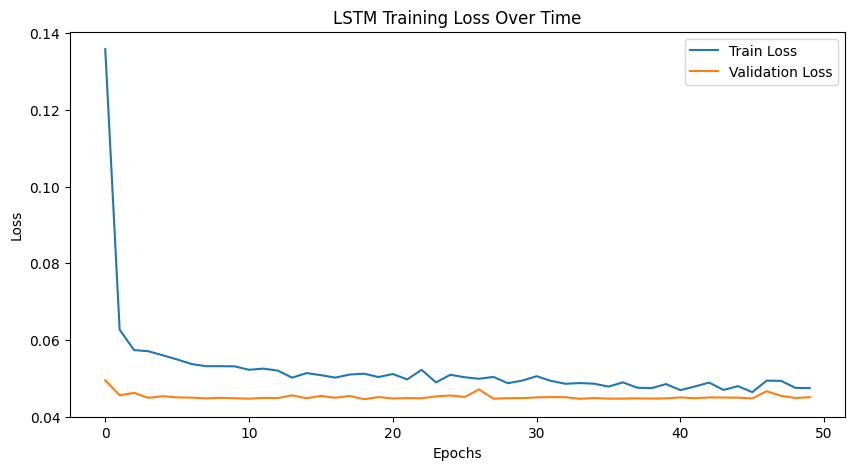

    Actual  Predicted
0      7.0   6.630795
1     21.0  13.624882
2     22.0  20.560625
3     30.0  28.032549
4     35.0  34.951931
5     39.0  42.147369
6      6.0   7.259915
7     30.0  14.073092
8     34.0  21.073732
9     45.0  27.626463
10    46.0  34.842010
11    48.0  42.412437
12     3.0   6.708911
13     6.0  13.319999
14     8.0  20.129808
15    11.0  26.976452
16    36.0  33.988556
17    48.0  41.538677
18     2.0   7.285695
19    11.0  14.046260
20    23.0  21.352514
21    24.0  27.765453
22    33.0  34.886402
23    44.0  42.329494
24     1.0   6.734454
25     4.0  13.487001
26     6.0  20.367290
27    15.0  27.300825
28    40.0  34.272320
29    44.0  41.820927


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load Dataset
df = pd.read_csv('./toto_cleaned_file.csv')

# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format="%d/%m/%Y")

# Extract useful date-based features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day_of_Week'] = df['Date'].dt.weekday  # Monday=0, Thursday=3

# Select relevant columns (winning numbers only)
winning_cols = [f'Winning Number {i}' for i in range(1, 7)]
data = df[winning_cols].copy()

# Normalize the data (LSTMs work better with scaled data)
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Prepare sequences for LSTM (we predict next set based on last 10 draws)
def create_sequences(data, sequence_length=10):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

sequence_length = 10
X, y = create_sequences(data_scaled, sequence_length)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(6, activation='linear')  # Predicting 6 winning numbers
])

# Compile model
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# Predict next draw
y_pred = model.predict(X_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)  # Convert back to original scale

# Evaluate model
mse = model.evaluate(X_test, y_test)
print(f'Mean Squared Error: {mse}')

# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('LSTM Training Loss Over Time')
plt.legend()
plt.show()

# Show a few predictions vs actual values
comparison = pd.DataFrame({'Actual': scaler.inverse_transform(y_test)[:5].flatten(),
                           'Predicted': y_pred_rescaled[:5].flatten()})
print(comparison)
